# CNN-Model for Image Classificaiton (CIFAR-10)

The following notebook shows the process of building and training a CNN model for image-classification using tensorflow and keras. 

I will use the well known [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) which consists of 60000 32x32 RGB images from ten different classes (vehicles as well as animals): 
- airplane,
- automobile,
- bird,
- cat,
- deer,
- dog,
- frog,
- horse, 
- ship,
- truck.

The model we are going to build will have a (comparably) simple architecture with (only) 420,842 parameters in total, still reaching an accuracy on the test set of around %.

## 1. Import Dependencies and load Data

In [66]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from utils import PlotModelEval, PlotConfusionMatrix

# Deep learning
import tensorflow as tf
import tensorflow.keras as keras

# Data and preprocessing
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

# Model building
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D

# Regularizaiton
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

# Weights and Biases training tracking
import wandb
from wandb.keras import WandbCallback

'2.8.0'

In [67]:
# Check whether GPU can be accessed 
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [69]:
# Load data and store labels
num_classes = 10
cifar_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In the following we will plot two random example pictures from each of the ten categories:

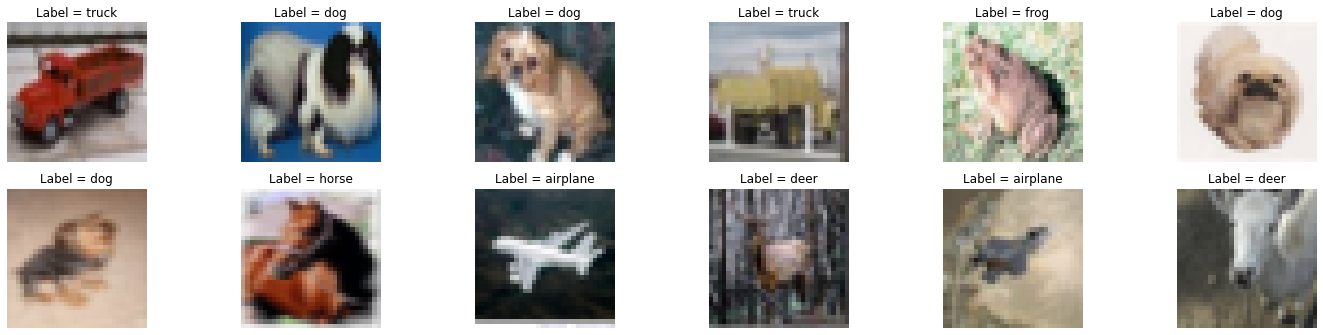

In [70]:
plt.figure(figsize=(20,5))
for i in range(12):
    idx = np.random.randint(0, len(y_train))
    label = y_train[idx,0]
    
    plt.subplot(2,6,i+1)
    plt.tight_layout()
    plt.imshow(X_train[idx])
    plt.title("Label = {}".format(cifar_labels[label]))
    plt.axis('off')
plt.show()

## 2. Preprocessing and Model building

In [71]:
# Transform label indices to one-hot encoded vectors
y_train = to_categorical(y_train, num_classes=10)
y_test  = to_categorical(y_test , num_classes=10)

# Normalization of pixel values (to [0-1] range)
X_train = X_train.astype('float32') / 255
X_test  = X_test.astype('float32')  / 255

### ImageGenerator
<br>
To reduce overfitting of the model, we will not only use EarlyStopping and Dropout, but we will also use an ImageGenerator, which adds random transformations (within borders you specify yourself) to the image. So our model will not be trained on the pure images themselves, but instead we will train an ImageGenerator, which will transform the Training-Batches before feeding them to the network.

In this way, the network will overfit less and generalize better since it never sees the same picture twice but always a slightly different version of it (e.g. rotated/flipped horizontally/...). 

The following code shows an ImageGenerator in action, which will rotate pictures up to 90 degrees, zoom in and out and flips the image horizontally (everything chosen random on the fly of course). You can clearly see the different transformations on the example pictures:

In [72]:
# Calling ImageGenerator 
datagen = ImageDataGenerator(rotation_range=90,
                             width_shift_range=0.1, 
                             height_shift_range=0.1,
                             horizontal_flip=True)

# Specify the flow, the original data and the batch size
flow = datagen.flow(X_train, y_train, batch_size=9) 

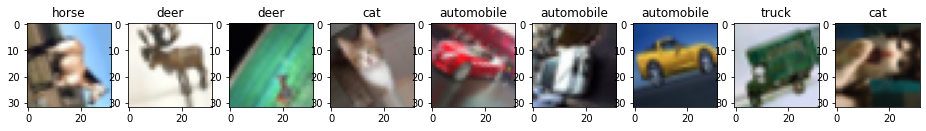

In [73]:
# Get one batch 
rnd_img_batch = flow.next()

plt.figure(figsize=(16, 64))
for i in range(9):
    plt.subplot(1, 9, i+1)
    image, label = rnd_img_batch[0][i], rnd_img_batch[1][i]
    plt.imshow(image)
    plt.title(cifar_labels[np.argmax(label)])

**Split training set into training and validation set**
<br>
Since the data is already shuffled, it is okay to simply take the first 10000 sample images as the validation set and the rest as the training set.

In [74]:
idx = round(0.2*X_train.shape[0])
X_val, X_train = X_train[:idx, ], X_train[idx:, ]
y_val, y_train = y_train[:idx, ], y_train[idx:, ]

In [75]:
print(f'Size of training-set  : {X_val.shape}')
print(f'Size of validation-set: {X_val.shape}')

(10000, 32, 32, 3)

### Weights and Biases setup

In [76]:
# Login to wandb
!wandb login "8ecf7403a425fa8a096aeedbe252d23586e2a4cc"

wandb: Appending key for api.wandb.ai to your netrc file: /Users/patrickhiemsch/.netrc


In [77]:
# Iterator for model run count
i=40

In [78]:
# Initialize run with hyperparameters 
batch_size = 64
epochs = 200
learning_rate = 0.0025 


wandb.config = {
  "learning_rate": learning_rate,
  "epochs": epochs,
  "batch_size": batch_size
}

wandb.init(project="CIFAR10-Classification", 
           entity="patricksvm",
           config=wandb.config,
           name = f"CIFAR-Run-{i}")

i+=1

accuracy,▁▃▄▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▄▆▅▆▆▆▇▇▇▇▇▇▇▇█▇████▇▇███▇███▇█████▇█▇
val_loss,█▅▄▃▄▃▂▃▂▂▂▂▂▂▂▂▁▂▁▁▁▂▂▁▁▁▁▂▁▁▁▂▁▂▁▂▁▂▁▂
accuracy,0.91805
best_epoch,107
best_val_loss,0.31929
epoch,145
loss,0.23808
val_accuracy,0.8785


### Build and train the model

We will train 

In [ ]:
def build_model(input_shape=X_train.shape[1:], num_classes=num_classes):
    """
    Function that builds our custom model and returns it.
    
    """
    # Set up Sequential model
    model = Sequential()
    
    # First block, 2x Conv2D(32 filters) and MaxPooling
    model.add(Conv2D(32, (3,3), padding='same', input_shape=input_shape))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3,3), padding='same'))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    
    # Second block, 2x Conv2D(64 filters) and MaxPooling 
    model.add(Conv2D(64, (3,3), padding='same')) 
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3,3), padding='same'))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    
    # Third block, 2x Conv2D(128 filters) and MaxPooling
    model.add(Conv2D(128, (3,3), padding='same'))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3,3), padding='same'))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))

    # Fully connected part with 64 hidden neurons
    model.add(Flatten())
    model.add(Dense(64))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))

    model.summary()
    
    return model

In [79]:
model = build_model()

# Setup ImageGenerator with best hyperparameters
datagen = ImageDataGenerator(rotation_range=17, #15
                             width_shift_range=0.08, #0.1
                             height_shift_range=0.08, #0.1
                             horizontal_flip=True)

# Setup flow
flow_train = datagen.flow(X_train, y_train, batch_size=batch_size)

# Specify early stopping
early_stop = EarlyStopping(monitor='val_accuracy', mode='max', patience=35, verbose=1, restore_best_weights=True)

# Compile model
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Nadam(learning_rate=learning_rate), metrics=['accuracy'])

# Train model
hist = model.fit(flow_train,
                 steps_per_epoch=(X_train.shape[0]) // batch_size,
                 epochs=epochs,
                 validation_data=(X_val, y_val),
                 callbacks=[WandbCallback(), early_stop],
                 verbose=1)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 activation_36 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 batch_normalization_42 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_37 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 activation_37 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 batch_normalization_43 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                     

2022-08-15 20:09:00.043697: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


625/625 [==============================] - ETA: 0s - loss: 1.4323 - accuracy: 0.4924

2022-08-15 20:09:52.307000: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


625/625 [==============================] - 60s 90ms/step - loss: 1.4323 - accuracy: 0.4924 - val_loss: 1.2798 - val_accuracy: 0.5666 - _timestamp: 1660586999.0000 - _runtime: 64.0000
Epoch 2/200
625/625 [==============================] - 57s 91ms/step - loss: 1.0191 - accuracy: 0.6410 - val_loss: 0.9206 - val_accuracy: 0.6766 - _timestamp: 1660587055.0000 - _runtime: 120.0000
Epoch 3/200
625/625 [==============================] - 56s 90ms/step - loss: 0.8792 - accuracy: 0.6938 - val_loss: 0.9991 - val_accuracy: 0.6578 - _timestamp: 1660587112.0000 - _runtime: 177.0000
Epoch 4/200
625/625 [==============================] - 58s 92ms/step - loss: 0.7984 - accuracy: 0.7243 - val_loss: 0.7034 - val_accuracy: 0.7605 - _timestamp: 1660587169.0000 - _runtime: 234.0000
Epoch 5/200
625/625 [==============================] - 57s 91ms/step - loss: 0.7378 - accuracy: 0.7454 - val_loss: 0.6418 - val_accuracy: 0.7778 - _timestamp: 1660587226.0000 - _runtime: 291.0000
Epoch 6/200
625/625 [============

Epoch 43/200
625/625 [==============================] - 54s 87ms/step - loss: 0.3666 - accuracy: 0.8707 - val_loss: 0.3923 - val_accuracy: 0.8714 - _timestamp: 1660589324.0000 - _runtime: 2389.0000
Epoch 44/200
625/625 [==============================] - 57s 91ms/step - loss: 0.3574 - accuracy: 0.8755 - val_loss: 0.3824 - val_accuracy: 0.8719 - _timestamp: 1660589380.0000 - _runtime: 2445.0000
Epoch 45/200
625/625 [==============================] - 58s 93ms/step - loss: 0.3538 - accuracy: 0.8795 - val_loss: 0.3970 - val_accuracy: 0.8724 - _timestamp: 1660589438.0000 - _runtime: 2503.0000
Epoch 46/200
625/625 [==============================] - 58s 93ms/step - loss: 0.3499 - accuracy: 0.8786 - val_loss: 0.4015 - val_accuracy: 0.8708 - _timestamp: 1660589496.0000 - _runtime: 2561.0000
Epoch 47/200
625/625 [==============================] - 58s 93ms/step - loss: 0.3414 - accuracy: 0.8828 - val_loss: 0.3614 - val_accuracy: 0.8828 - _timestamp: 1660589554.0000 - _runtime: 2619.0000
Epoch 48/2

625/625 [==============================] - 56s 90ms/step - loss: 0.2895 - accuracy: 0.8979 - val_loss: 0.3703 - val_accuracy: 0.8827 - _timestamp: 1660591603.0000 - _runtime: 4668.0000
Epoch 85/200
625/625 [==============================] - 55s 88ms/step - loss: 0.2909 - accuracy: 0.8983 - val_loss: 0.4030 - val_accuracy: 0.8718 - _timestamp: 1660591658.0000 - _runtime: 4723.0000
Epoch 86/200
625/625 [==============================] - 54s 87ms/step - loss: 0.2867 - accuracy: 0.8995 - val_loss: 0.3582 - val_accuracy: 0.8821 - _timestamp: 1660591712.0000 - _runtime: 4777.0000
Epoch 87/200
625/625 [==============================] - 54s 87ms/step - loss: 0.2819 - accuracy: 0.9011 - val_loss: 0.3470 - val_accuracy: 0.8914 - _timestamp: 1660591767.0000 - _runtime: 4832.0000
Epoch 88/200
625/625 [==============================] - 54s 87ms/step - loss: 0.2746 - accuracy: 0.9037 - val_loss: 0.3625 - val_accuracy: 0.8857 - _timestamp: 1660591821.0000 - _runtime: 4886.0000
Epoch 89/200
625/625 [=

625/625 [==============================] - 55s 88ms/step - loss: 0.2486 - accuracy: 0.9110 - val_loss: 0.3459 - val_accuracy: 0.8926 - _timestamp: 1660593906.0000 - _runtime: 6971.0000
Epoch 126/200
625/625 [==============================] - 55s 88ms/step - loss: 0.2472 - accuracy: 0.9142 - val_loss: 0.3421 - val_accuracy: 0.8929 - _timestamp: 1660593961.0000 - _runtime: 7026.0000
Epoch 127/200
625/625 [==============================] - 56s 89ms/step - loss: 0.2541 - accuracy: 0.9110 - val_loss: 0.3676 - val_accuracy: 0.8856 - _timestamp: 1660594017.0000 - _runtime: 7082.0000
Epoch 128/200
625/625 [==============================] - 56s 90ms/step - loss: 0.2463 - accuracy: 0.9131 - val_loss: 0.3512 - val_accuracy: 0.8896 - _timestamp: 1660594073.0000 - _runtime: 7138.0000
Epoch 129/200
625/625 [==============================] - 57s 91ms/step - loss: 0.2449 - accuracy: 0.9148 - val_loss: 0.3371 - val_accuracy: 0.8962 - _timestamp: 1660594130.0000 - _runtime: 7195.0000
Epoch 130/200
625/6

625/625 [==============================] - 55s 88ms/step - loss: 0.2280 - accuracy: 0.9189 - val_loss: 0.3683 - val_accuracy: 0.8917 - _timestamp: 1660596213.0000 - _runtime: 9278.0000
Epoch 167/200
625/625 [==============================] - 55s 88ms/step - loss: 0.2296 - accuracy: 0.9190 - val_loss: 0.3280 - val_accuracy: 0.8975 - _timestamp: 1660596268.0000 - _runtime: 9333.0000
Epoch 168/200
625/625 [==============================] - 55s 88ms/step - loss: 0.2250 - accuracy: 0.9223 - val_loss: 0.3278 - val_accuracy: 0.8978 - _timestamp: 1660596323.0000 - _runtime: 9388.0000
Epoch 169/200
625/625 [==============================] - 55s 88ms/step - loss: 0.2284 - accuracy: 0.9196 - val_loss: 0.3464 - val_accuracy: 0.8946 - _timestamp: 1660596378.0000 - _runtime: 9443.0000
Epoch 170/200
625/625 [==============================] - 55s 88ms/step - loss: 0.2264 - accuracy: 0.9207 - val_loss: 0.3496 - val_accuracy: 0.8929 - _timestamp: 1660596433.0000 - _runtime: 9498.0000
Epoch 171/200
625/6




========== lr: 0.0025 ==========




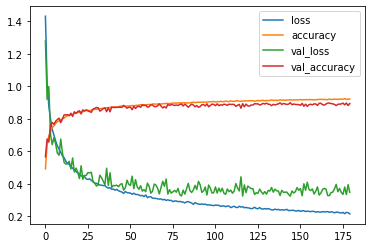

Test loss = 0.336
Test accuracy = 0.891


In [80]:
print(f"\n\n\n========== lr: {learning_rate} ==========")
score = model.evaluate(X_test, y_test, batch_size=128, verbose=0)
print("\n")
pd.DataFrame(hist.history).iloc[:,:4].plot()
plt.show()
for i in range(len(score)):
      print("Test " + model.metrics_names[i] + " = %.3f" % score[i])


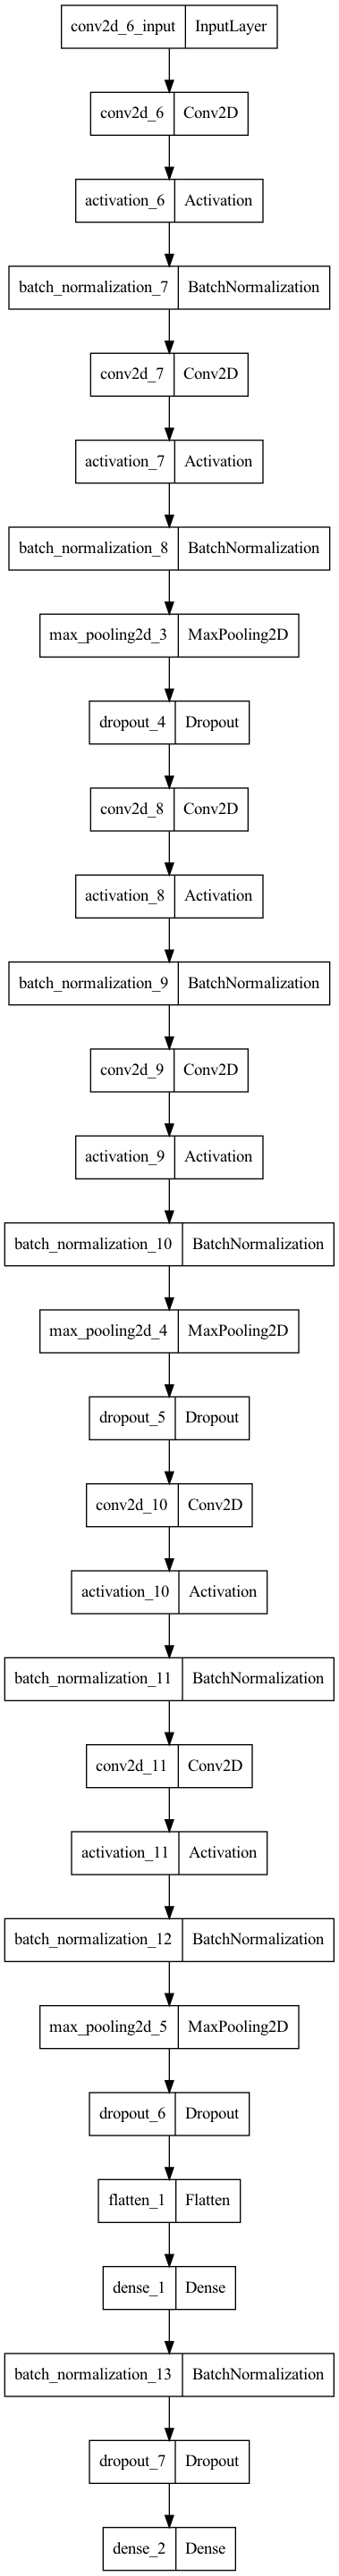

In [8]:
from tensorflow.keras.utils import plot_model

plot_model(model)